In [1]:
import os
import pickle
import numpy as np
# from tqdm.notebook import tqdm
import warnings
# from tqdm import tqdm
from keras.applications.vgg16 import VGG16,preprocess_input
from keras.applications import ResNet50, DenseNet201
# from keras.preprocessing.image import load_img,img_to_arra
from keras.preprocessing.text import Tokenizer
# from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.utils import to_categorical,plot_model
from keras.layers import Input,Dense,LSTM,Embedding,Dropout,add
import numpy as np
import pandas as pd
import cv2
import os
from glob import glob
import pickle
from tqdm.notebook import tqdm
import tensorflow as tf
from tensorflow import keras
from keras.applications.vgg16 import VGG16,preprocess_input
#from keras.preprocessing.image import load_img,img_to_array
from keras.preprocessing import image

from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array

#from keras.preprocessing.sequence import pad_sequences
from keras.utils import pad_sequences

from keras.models import Model
from keras.utils import to_categorical,plot_model
from keras.layers import Input,Dense,LSTM,Embedding,Dropout,add

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
Base_Dir = '/kaggle/input/flickr8k'
Working_Dir = '/kaggle/working/'

## EXTRACT IMAGE FEATURES

In [3]:
#load resnet50 model
model_resnet= ResNet50()
#restructuring the model since we don't need the last predicition layer(softmax layer)
model_resnet = Model(inputs = model_resnet.inputs, outputs = model_resnet.layers[-2].output)
#summarize
model_resnet.summary()


102967424/102967424 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                           

In [4]:
model_resnet.save_weights('model_resnet_weights.h5')

In [10]:
extract features from image
features = {}
directory = os.path.join(Base_Dir,'Images')

for img_name in os.listdir(directory):
    
    #load image from the file
    img_path = directory + '/' + img_name
    image = load_img(img_path,target_size=(224,224))
    
    #convert image pixel into numpy array
    image = img_to_array(image)
    
    # reshape the data for model to exact features
    image = image.reshape((1,image.shape[0],image.shape[1],image.shape[2]))
    
    #preprocess the image for resnet50
    image = preprocess_input(image)
    
    #extracting features
    feature = model_resnet.predict(image,verbose=0)
    
    #get the image id
    image_id = img_name.split('.')[0]
    
    # store the feature in the dictionary
    features[image_id] = feature


In [11]:
#storing features in pickle
# this will save us re-running the above cell every time we start a new session
pickle.dump(features, open(os.path.join(Working_Dir, 'features.pkl'), 'wb'))

In [3]:
import os


In [4]:
# load features from pickle
# the features computed aboove are now stored in /kaggle/input/features/features.pkl , so we need to load the features before going further
with open(os.path.join(Working_Dir, 'features.pkl') ,'rb') as f:
    features = pickle.load(f)

In [5]:
len(features)

8091

## LOAD THE CAPTION DATA

In [6]:
with open(os.path.join(Base_Dir, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [7]:
#creating mapping from image to caption 
mapping={}

# preprocessing the lines
for line in captions_doc.split('\n'):
    #split the lines by comma
    tokens = line.split(',')
    if len(line) <2:
        continue
        
    image_id,captions = tokens[0],tokens[1:]
    # removing extension from image_ids
    image_id = image_id.split('.')[0]
    #convert caption list into string 
    captions = " ".join(captions)
    #since every image has around 5 captions , so we will store them in a list
    if image_id not in mapping:
        mapping[image_id] = []
    mapping[image_id].append(captions)
    
    
    
    

In [8]:
len(mapping)

8091

In [9]:
# preprocess the captions
def clean_cap(mapping):
    for key,captions in mapping.items():
        for i in range(len(captions)):
            #taking one caption at a time
            caption = captions[i]
            #preprocessing the captions
            #convert to lower case
            caption = caption.lower()
            #delete digits, special chars, etc.
            caption = caption.replace('[^A_Za-z]', '')
            #delete additonal spaces
            caption = caption.replace('\s+',' ')
            # add start and end tags to the caption and removing words with length 1
            caption = 'startseq ' + ' '.join([word for word in caption.split() if len(word) > 1]) + ' endseq'
            captions[i] = caption
            

In [10]:
#before preprocess of captions
mapping['1001773457_577c3a7d70'

['A black dog and a spotted dog are fighting',
 'A black dog and a tri-colored dog playing with each other on the road .',
 'A black dog and a white dog with brown spots are staring at each other in the street .',
 'Two dogs of different breeds looking at each other on the road .',
 'Two dogs on pavement moving toward each other .']

In [10]:
#after preprocessing of captions
clean_cap(mapping)
mapping['1001773457_577c3a7d70']

['startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [11]:
all_captions =[]
for key in mapping:
    for captions in mapping[key]:
        all_captions.append(captions)

In [12]:
len(all_captions)

40455

In [13]:
from tensorflow.keras.preprocessing.text import Tokenizer


In [14]:
# Tokenizing the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index)+1

In [15]:
vocab_size

8485

In [16]:
# get maximum length of the caption available 
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

## TRAIN TEST SPLIT

In [17]:
image_id = list(mapping.keys())
split = int(len(image_id)*0.90)
train = image_id[:split]
test = image_id[split:]

In [18]:
test[:4]

['436015762_8d0bae90c3',
 '436393371_822ee70952',
 '436608339_f1d1298770',
 '437054333_5c2761b8cd']

In [20]:
len(test)

810

In [19]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

## MODEL CREATION

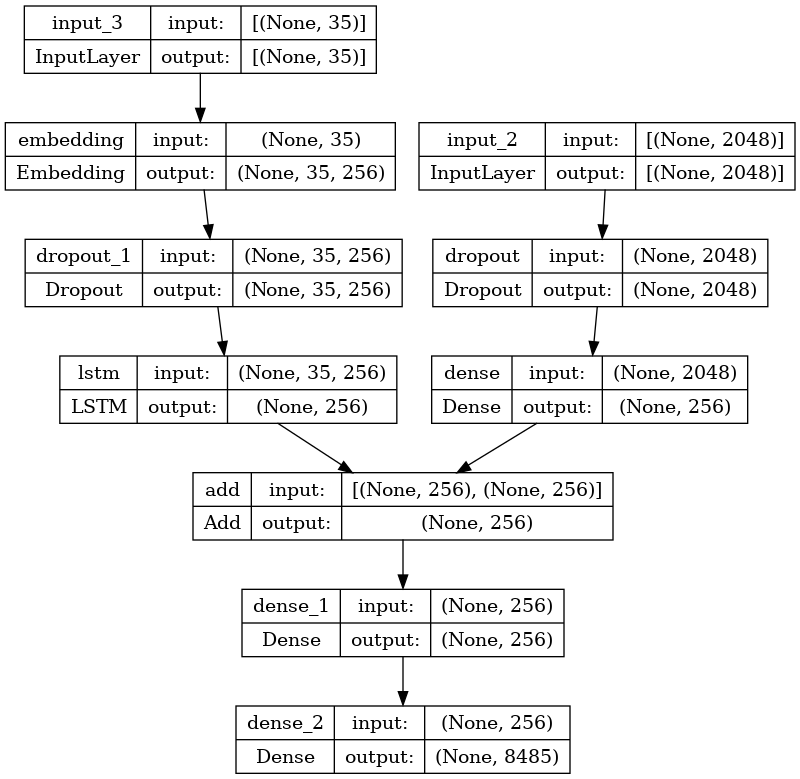

In [20]:
## encoder model
# image feature layers
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.2)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.2)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

models = Model(inputs=[inputs1, inputs2], outputs=outputs)
models.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

plot_model(models, show_shapes=True)



In [21]:
epochs = 40
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    models.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

227/227 [==============================] - 74s 327ms/step - loss: 1.6413 - accuracy: 0.5522


In [22]:
models.save('models_40.h5')

In [23]:
import pickle
# saving
with open('tokenizer40.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [24]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None  

In [25]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
      
    return in_text

In [26]:
# again 40
import nltk

from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in test[:20]:
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(models, features[key], tokenizer, 35) 
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
    
# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

BLEU-1: 0.538153
BLEU-2: 0.321559


In [27]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(Base_Dir, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(models, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq man in an orange hat starring at something endseq
startseq man wears an orange hat and glasses endseq
startseq man with gauges and glasses is wearing blitz hat endseq
startseq man with glasses is wearing beer can crocheted hat endseq
startseq the man with pierced ears is wearing glasses and an orange hat endseq
--------------------Predicted--------------------
startseq man wearing glasses and glasses is wearing blitz hat endseq


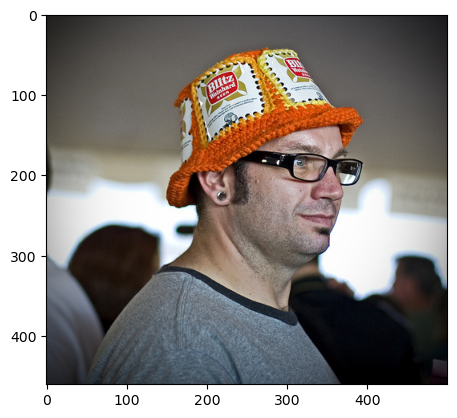

In [28]:
generate_caption("1007129816_e794419615.jpg")

---------------------Actual---------------------
startseq girl in pink and yellow on pink and orange surfboard cuts through the wave endseq
startseq surfer rides the wave endseq
startseq woman in yellow shirt surfs on pink surfboard endseq
startseq woman on surfboard rides wave endseq
startseq the girl catches wave on her pink surfboard endseq
--------------------Predicted--------------------
startseq surfer in yellow and yellow going down the side of the hill endseq


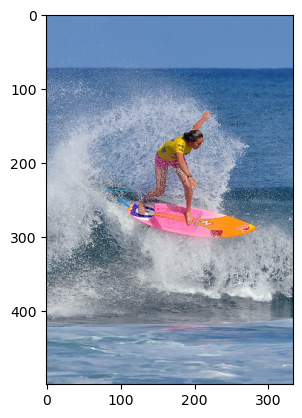

In [29]:
generate_caption("3707990914_843e8f15f1.jpg")

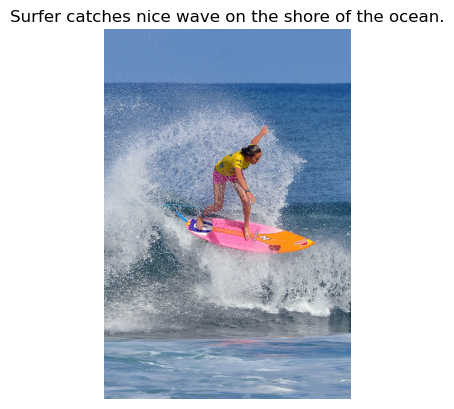

In [30]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

def preprocess_image(image_path):
    image = Image.open(image_path)
    image = image.resize((224, 224))  # Resize the image to match VGG16 input size
    image = np.array(image)
    image = preprocess_input(image)
    return image

def generate_caption_for_new_image(image_path):
    # Preprocess the image
    new_image = preprocess_image(image_path)

    # Generate features for the new image using the pre-trained VGG16 model
    resnet_model = ResNet50()
    resnet_model=  Model(inputs=resnet_model.inputs, outputs=resnet_model.layers[-2].output)
#     vgg_model = Model(inputs=vgg_model.inputs, outputs=vgg_model.layers[-2].output)
    new_image_features = resnet_model.predict(np.array([new_image]), verbose=0)

    # Predict caption for the new image
    predicted_caption = predict_caption(models, new_image_features, tokenizer, max_length)

    # Remove startseq and endseq tokens
    predicted_caption = predicted_caption.replace('startseq', '').replace('endseq', '').strip()

    # Capitalize the first letter
    predicted_caption = predicted_caption.capitalize()

    # Add a full stop at the end if not present
    if not predicted_caption.endswith('.'):
        predicted_caption += '.'

    # Display the image and the predicted caption
    plt.imshow(Image.open(image_path))
    plt.title(predicted_caption)
    plt.axis('off')
    plt.show()
# Specify the path to the new image
new_image_path = "/kaggle/input/flickr8k/Images/3707990914_843e8f15f1.jpg"
generate_caption_for_new_image(new_image_path)

In [ ]:
import urllib
from PIL import Image

# Download and preprocess the image
image_url = "https://scontent.fcgp3-2.fna.fbcdn.net/v/t39.30808-6/342803733_1405586023532018_5326723090263292674_n.jpg?stp=dst-jpg_p526x296&_nc_cat=109&ccb=1-7&_nc_sid=8bfeb9&_nc_ohc=umsFTd2IxDAAX_3ND1n&_nc_ht=scontent.fcgp3-2.fna&oh=00_AfCMX98IGiOC8O5dtehUN_E2P1xYC548YYRP25SJyvjJag&oe=64F0C67B" # Replace with the URL of the image you want to caption
image_path = "image.jpg"  # Replace with the desired path to save the image file

# Download the image
urllib.request.urlretrieve(image_url, image_path)

# Preprocess the image
image = load_img(image_path, target_size=(224, 224))
image = img_to_array(image)
image = preprocess_input(image)
image = np.expand_dims(image, axis=0)
plt.imshow(Image.open(image_path))
# plt.title(predicted_caption)
plt.axis('off')
plt.show()

# Extract features from the image
image_features = model_resnet.predict(image)

# Generate caption
predicted_caption = predict_caption(models, image_features, tokenizer, max_length)
print(predicted_caption)

---------------------Actual---------------------
startseq man in hat is displaying pictures next to skier in blue hat endseq
startseq man skis past another man displaying paintings in the snow endseq
startseq person wearing skis looking at framed pictures set up in the snow endseq
startseq skier looks at framed pictures in the snow next to trees endseq
startseq man on skis looking at artwork for sale in the snow endseq
--------------------Predicted--------------------
startseq man wearing black coat skis down the snow endseq


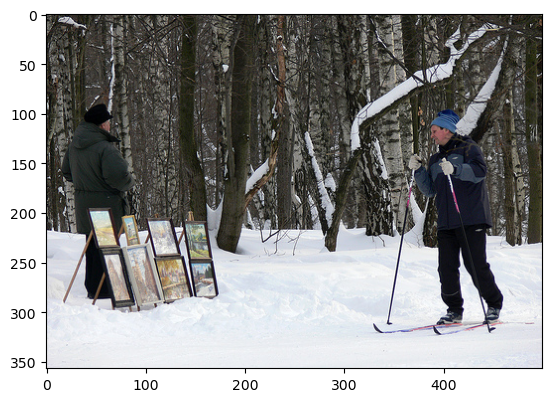

In [31]:
generate_caption("101669240_b2d3e7f17b.jpg")

---------------------Actual---------------------
startseq girl in pink coat plays in the leaves endseq
startseq girl in pink coat throws leaves in the air endseq
startseq little girl in pink jacket throwing some leafs up in the air endseq
startseq little girl in pink jacket throws leaves over her head in front of fence endseq
startseq young girl in pink coat throwing leaves into the air endseq
--------------------Predicted--------------------
startseq little girl throws her leaves into the air endseq


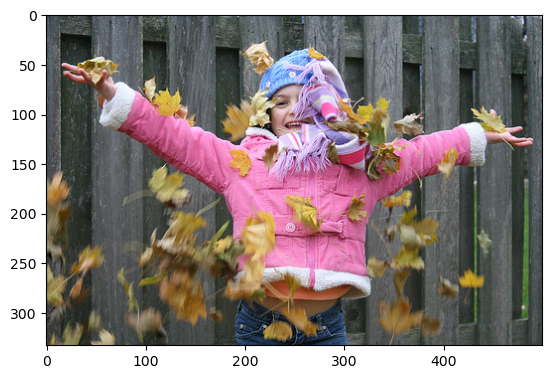

In [32]:
generate_caption("3707738261_777075e885.jpg")

---------------------Actual---------------------
startseq black dog running in the surf endseq
startseq black lab with tags frolicks in the water endseq
startseq dog splashes in the water endseq
startseq the black dog runs through the water endseq
startseq this is black dog splashing in the water endseq
--------------------Predicted--------------------
startseq black dog is in the water with red object in its mouth endseq


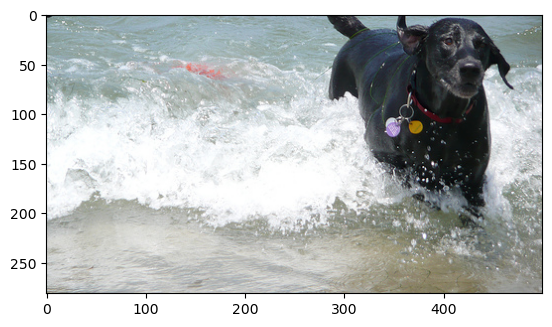

In [33]:
generate_caption("1022975728_75515238d8.jpg")

---------------------Actual---------------------
startseq two different breeds of brown and white dogs play on the beach endseq
startseq two dogs are making turn on soft sand beach endseq
startseq two dogs playing in the sand at the beach endseq
startseq two dogs playing together on beach endseq
startseq two large tan dogs play along sandy beach endseq
--------------------Predicted--------------------
startseq two dogs play together on the beach endseq


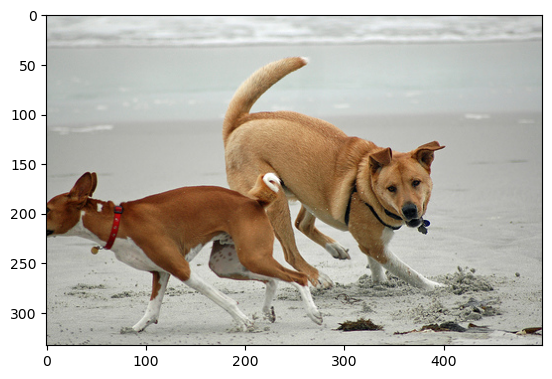

In [34]:
generate_caption("1024138940_f1fefbdce1.jpg")

---------------------Actual---------------------
startseq "a couple and an infant being held by the male sitting next to pond with near by stroller ." endseq
startseq couple sit on the grass with baby and stroller endseq
startseq couple with their newborn baby sitting under tree facing lake endseq
startseq man and woman care for an infant along the side of body of water endseq
startseq couple with baby sit outdoors next to their stroller endseq
--------------------Predicted--------------------
startseq two men are sitting on bench and one is wearing black hat endseq


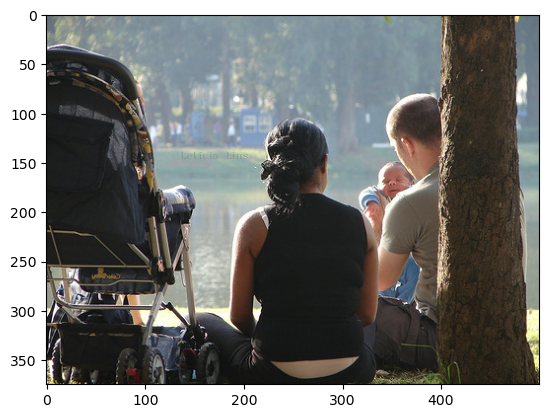

In [35]:
generate_caption("1022454428_b6b660a67b.jpg")

---------------------Actual---------------------
startseq boy in blue shorts slides down slide into pool endseq
startseq boy in blue swimming trunks slides down yellow slide into wading pool with inflatable toys floating in the water endseq
startseq boy rides down slide into small backyard pool endseq
startseq boy sliding down slide into pool with colorful tubes endseq
startseq child is falling off slide onto colored balloons floating on pool of water endseq
--------------------Predicted--------------------
startseq child wearing foam shirt slides down slide into pool endseq


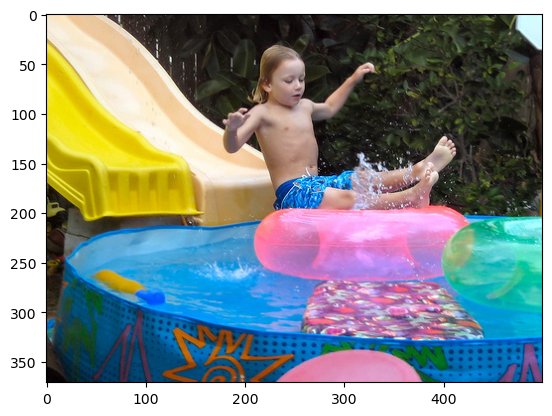

In [36]:
generate_caption("1077546505_a4f6c4daa9.jpg")

---------------------Actual---------------------
startseq person on snowmobile in mid jump endseq
startseq snowmobiler flies through the air endseq
startseq snowmobile rider flies through the air on his or her machine in front of tall pine trees endseq
startseq rider jumps snowmobile high in rural area endseq
startseq the man is up in the air endseq
--------------------Predicted--------------------
startseq snowmobile rider flies through the air endseq


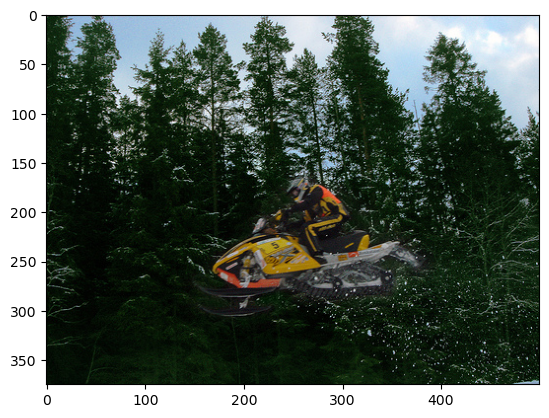

In [37]:
generate_caption("109738763_90541ef30d.jpg")